<a href="https://colab.research.google.com/github/joao-vitor-braga/ibovespa-trend-prediction-time-series-machine-learning/blob/main/ibovespa_trend_prediction_time_series_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Previsão de Tendência do IBOVESPA**


#####**Grupo: 126 - Ariany, Érica, João Vitor, Juliana e Willer.**


Pós-Graduação em Data Analytics


###**1. Contexto do Problema**

Você foi alocado em uma equipe de cientistas de dados de um grande fundo de investimentos brasileiro. O objetivo é prever se o IBOVESPA fechará em alta (↑) ou baixa (↓) no próximo pregão, utilizando apenas dados históricos do próprio índice.

###**2. Objetivo do Projeto**

Construir um modelo de classificação binária capaz de prever a tendência do IBOVESPA no dia seguinte, atendendo aos seguintes critérios:

**Target:**

1 (Alta) se Close(t+1) > Close(t)

0 (Baixa) caso contrário

Base histórica: últimos 20 anos (dados diários)

Conjunto de teste: últimos 30 dias

Métrica principal: Acurácia ≥ 75%
Outras métricas: F1-Score, Classification Report (precision, recall), Confusion Matrix

###**3. Aquisição dos Dados**

Os dados foram obtidos a partir do site Investing.com:

🔗 https://br.investing.com/indices/bovespa-historical-data

A periodicidade escolhida foi a diária, considerando os últimos 20 anos de dados, em formato CSV com sep= ','.


In [1]:
# -- Importando as bibliotecas

import warnings
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import yfinance as yf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# -- Leitura dos dados e padronização da data como index

from pathlib import Path
import pandas as pd

LOCAL_PATH = Path("ibovespa_historical_daily.csv")
REMOTE_URL = (
    "https://raw.githubusercontent.com/"
    "joao-vitor-braga/"
    "ibovespa-trend-prediction-time-series-machine-learning/"
    "main/ibovespa_historical_daily.csv"
)

if LOCAL_PATH.exists():
    df_ibov = pd.read_csv(LOCAL_PATH)
else:
    print("Arquivo local não encontrado. Baixando do GitHub...")
    df_ibov = pd.read_csv(REMOTE_URL)

df_ibov['Data'] = pd.to_datetime(df_ibov['Data'], dayfirst=True)
df_ibov = df_ibov.sort_values('Data').reset_index(drop=True)
df_ibov.set_index('Data', inplace=True)

df_ibov.head()


Arquivo local não encontrado. Baixando do GitHub...


,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2006-01-02,33.507,33.462,33.519,32.860,"72,32M","0,15%"
2006-01-03,34.541,33.507,34.563,33.507,"148,38M","3,09%"
2006-01-04,35.002,34.540,35.223,34.540,"147,13M","1,33%"
2006-01-05,34.936,35.006,35.088,34.681,"142,07M","-0,19%"
2006-01-06,35.475,35.170,35.529,34.940,"115,09M","1,54%"


In [3]:
## -- Visualizando a estrutura do dataframe

df_ibov.shape

(4962, 6)

In [4]:
df_ibov.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2026-01-07,161.975,163.661,163.661,161.746,"8,85B","-1,03%"
2026-01-08,162.936,161.975,162.936,161.748,"8,61B","0,59%"
2026-01-09,163.370,162.938,164.263,162.638,"8,30B","0,27%"
2026-01-12,163.150,163.370,163.493,162.277,"6,90B","-0,13%"
2026-01-13,161.973,163.146,163.146,161.765,"9,67B","-0,72%"


In [5]:
# -- Identificando que a data está colocada como object

df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4962 entries, 2006-01-02 to 2026-01-13
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    4962 non-null   float64
 1   Abertura  4962 non-null   float64
 2   Máxima    4962 non-null   float64
 3   Mínima    4962 non-null   float64
 4   Vol.      4961 non-null   object 
 5   Var%      4962 non-null   object 
dtypes: float64(4), object(2)
memory usage: 271.4+ KB


In [6]:
## -- Padronizando os nomes das colunas
df_ibov.columns = ['Fechamento', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Variação']
df_ibov.head()

,Fechamento,Abertura,Maxima,Minima,Volume,Variação
Data,,,,,,
2006-01-02,33.507,33.462,33.519,32.860,"72,32M","0,15%"
2006-01-03,34.541,33.507,34.563,33.507,"148,38M","3,09%"
2006-01-04,35.002,34.540,35.223,34.540,"147,13M","1,33%"
2006-01-05,34.936,35.006,35.088,34.681,"142,07M","-0,19%"
2006-01-06,35.475,35.170,35.529,34.940,"115,09M","1,54%"


In [7]:
## -- .info() do dataframe

df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4962 entries, 2006-01-02 to 2026-01-13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Fechamento  4962 non-null   float64
 1   Abertura    4962 non-null   float64
 2   Maxima      4962 non-null   float64
 3   Minima      4962 non-null   float64
 4   Volume      4961 non-null   object 
 5   Variação    4962 non-null   object 
dtypes: float64(4), object(2)
memory usage: 271.4+ KB


In [8]:
## -- Convertendo a coluna Volume para float64, removendo K, M e B.

def converte_volume(Volume):
    if pd.isna(Volume) or Volume == '-':
        return np.nan

    Volume = Volume.replace(',', '.')

    if 'K' in Volume:
        return float(Volume.replace('K', '')) * 1_000
    elif 'M' in Volume:
        return float(Volume.replace('M', '')) * 1_000_000
    elif 'B' in Volume:
        return float(Volume.replace('B', '')) * 1_000_000_000
    else:
        return float(Volume)

## -- Convertendo a coluna Variação para float64, removendo %.

df_ibov['Variação'] = (
    df_ibov['Variação']
    .str.replace('%', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
    / 100)

In [9]:
## -- Visualizando a coluna Volume

df_ibov['Volume'].head()
df_ibov['Volume'].apply(type).value_counts()

,count
Volume,
<class 'str'>,4961
<class 'float'>,1


In [10]:
## -- Convertendo a coluna que residual de str para float

df_ibov['Volume'] = df_ibov['Volume'].apply(converte_volume)
df_ibov['Volume'] = df_ibov['Volume'].astype('float64')

In [11]:
## -- .info() com as informações das colunas do dataframe após transformação da Data para datetime

df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4962 entries, 2006-01-02 to 2026-01-13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Fechamento  4962 non-null   float64
 1   Abertura    4962 non-null   float64
 2   Maxima      4962 non-null   float64
 3   Minima      4962 non-null   float64
 4   Volume      4961 non-null   float64
 5   Variação    4962 non-null   float64
dtypes: float64(6)
memory usage: 271.4 KB


In [12]:
## -- Estatísticas básicas do dataframe

df_ibov.describe()

,Fechamento,Abertura,Maxima,Minima,Volume,Variação
count,4962.000000,4962.000000,4962.000000,4962.000000,4.961000e+03,4962.000000
mean,77.880797,77.855412,78.582944,77.144428,4.839173e+08,0.000453
std,30.831332,30.814669,30.961200,30.692896,2.089098e+09,0.016436
min,29.435000,29.438000,31.480000,29.435000,1.121000e+05,-0.147800
25%,53.798000,53.796750,54.298500,53.143000,2.820000e+06,-0.007800
50%,65.748500,65.748000,66.274000,65.069000,4.430000e+06,0.000600
75%,105.807750,105.783000,106.780500,104.810000,1.089000e+07,0.009000
max,164.456000,164.461000,165.036000,162.638000,2.487000e+10,0.146600


In [13]:
## -- Verificando a existência de nulos nas colunas

df_ibov.isnull().sum()

,0
Fechamento,0
Abertura,0
Maxima,0
Minima,0
Volume,1
Variação,0


In [14]:
## -- Identificando o valor nulo da base

df_ibov[df_ibov["Volume"].isnull()]

,Fechamento,Abertura,Maxima,Minima,Volume,Variação
Data,,,,,,
2016-02-10,40.377,40.592,40.592,39.96,NaN,-0.0053


In [15]:
## -- Excluindo o valor nulo da base, apesar de ser apenas na coluna volume (como temos muitos dados, o impacto é baixíssimo)

df_ibov = df_ibov.dropna(subset=['Volume'])
df_ibov.isnull().sum()

,0
Fechamento,0
Abertura,0
Maxima,0
Minima,0
Volume,0
Variação,0


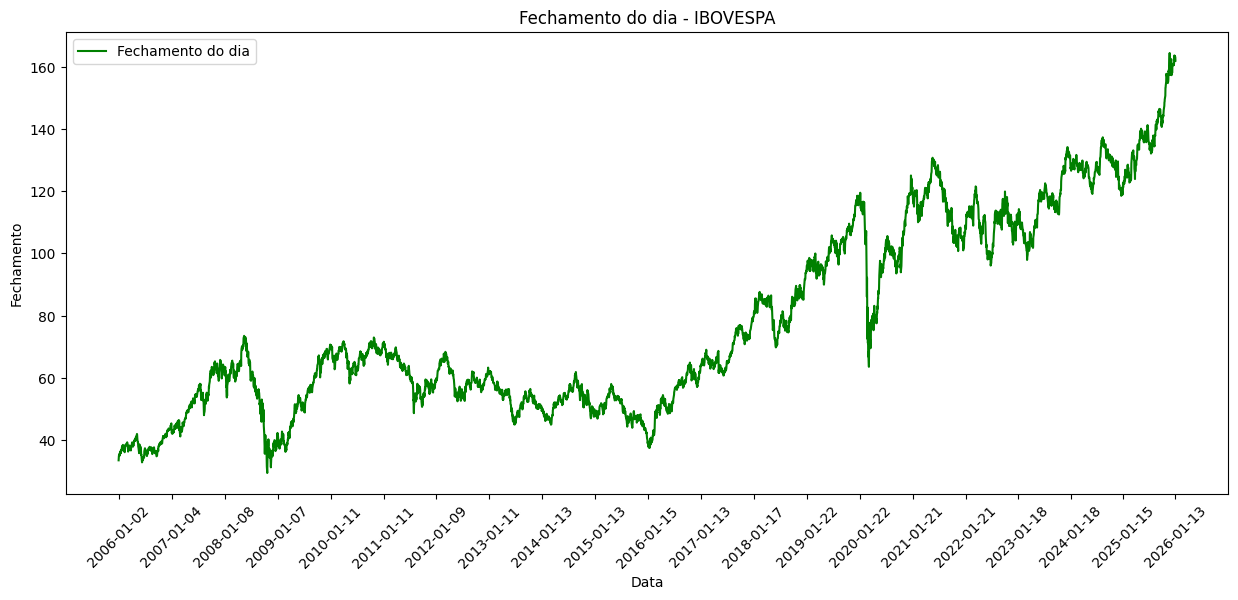

In [16]:
## -- Plotando a evolução histórica de fechamento - IBOVESPA nos últimos 20 anos

plt.figure(figsize=(15, 6))
plt.plot(df_ibov.index, df_ibov['Fechamento'], label='Fechamento do dia', color='green')
plt.title('Fechamento do dia - IBOVESPA')
plt.xlabel('Data')
plt.ylabel('Fechamento')

n_labels =   20
labels = df_ibov.index[::len(df_ibov) // n_labels]

plt.xticks(labels, rotation=45)

plt.legend()
plt.show()

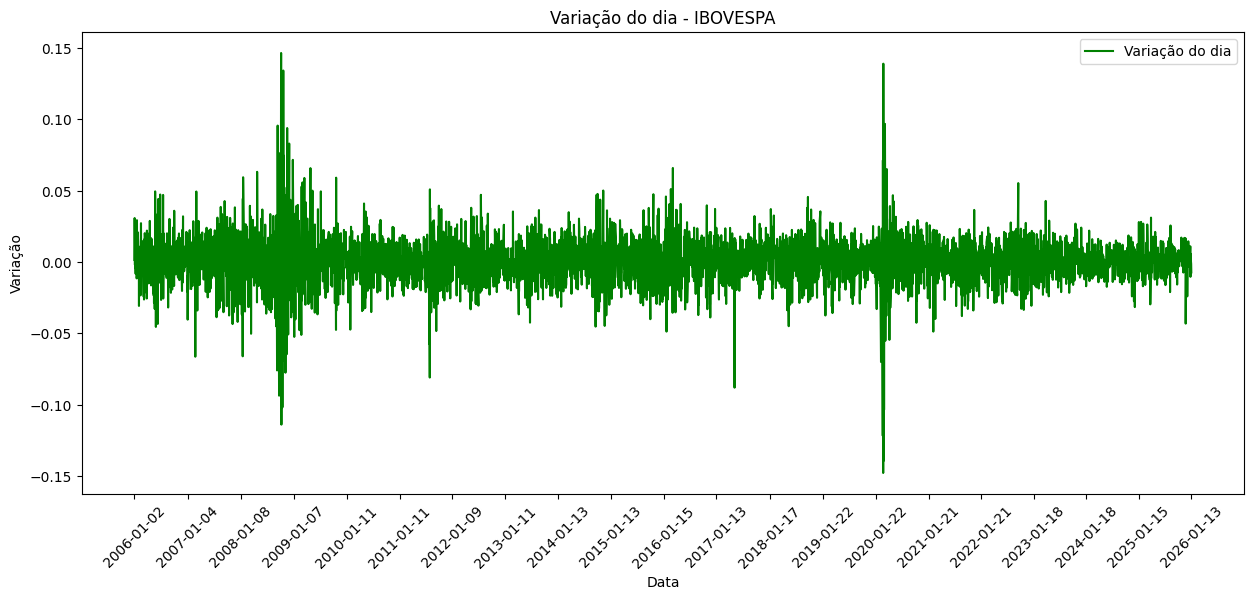

In [17]:
## -- Plotando a variação histórica da IBOVESPA nos últimos 20 anos

plt.figure(figsize=(15, 6))
plt.plot(df_ibov.index, df_ibov['Variação'], label='Variação do dia', color='green')
plt.title('Variação do dia - IBOVESPA')
plt.xlabel('Data')
plt.ylabel('Variação')

n_labels =   20
labels = df_ibov.index[::len(df_ibov) // n_labels]

plt.xticks(labels, rotation=45)

plt.legend()
plt.show()

##**Análise da Evolução Histórica do IBOVESPA (Últimos 5 anos)**

###**Principais pontos observados no gráfico:**

####**- Tendência de alta no longo prazo**
Apesar de períodos de forte volatilidade, o índice apresenta uma trajetória ascendente ao longo dos últimos 5 anos, especialmente a partir de 2023, indicando recuperação e crescimento do mercado acionário brasileiro.

####**- Alta volatilidade em períodos específicos**
Entre 2021 e 2022 observa-se maior instabilidade, com movimentos bruscos de alta e queda, refletindo um cenário de maior incerteza econômica e política.

####**- Forte movimento de valorização recente**
A partir de 2024, nota-se uma aceleração mais consistente da alta, culminando nos maiores níveis do período analisado, sugerindo maior confiança dos investidores e melhora no ambiente macroeconômico.

####**- Importância da análise temporal**
O gráfico evidencia como análises de curto prazo podem ser enganosas, enquanto a visualização histórica permite identificar padrões estruturais e ciclos de mercado. **Por isso selecionamos 20 anos. No início havíamos selecionado um período de 5 anos apenas.**


In [18]:
## -- Decomposição da série observada em sazonalidade, tendência e resíduo:

decomposiçao = seasonal_decompose(df_ibov['Fechamento'], model='additive', period=252)

## -- Importante comentar que o hiperparâmetro period = 252 representa os pregões por ano no mercado financeiro, ou seja, dias úteis que descontam feriados e finais de semana.


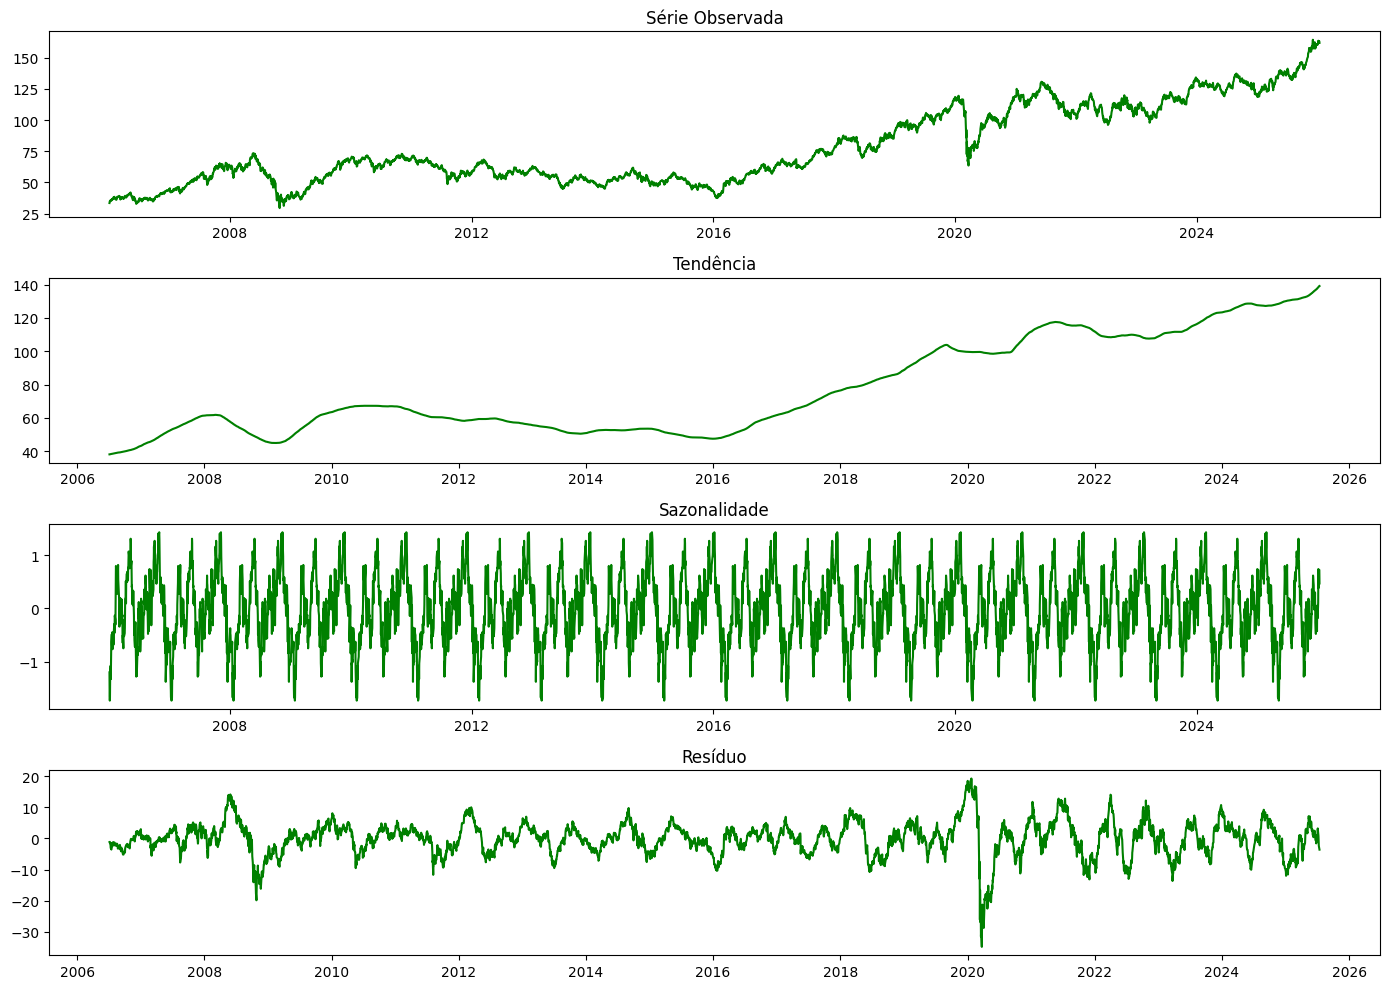

In [19]:
trend = decomposiçao.trend
seasonal = decomposiçao.seasonal
residual = decomposiçao.resid
observed = decomposiçao.observed

plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.plot(observed, color='green')
plt.title('Série Observada')

plt.subplot(4,1,2)
plt.plot(trend, color='green')
plt.title('Tendência')

plt.subplot(4,1,3)
plt.plot(seasonal, color='green')
plt.title('Sazonalidade')

plt.subplot(4,1,4)
plt.plot(residual, color='green')
plt.title('Resíduo')

plt.tight_layout()
plt.show()

In [20]:
## -- Realizando o teste de ADF, para verificar a estacionariedade da série temporal.

df_ibov_adf = df_ibov['Fechamento']
df_ibov_adf = df_ibov_adf.astype(float)
resultado_adf = adfuller(df_ibov_adf)
print("Teste Dickey-Fuller (ADF)\n")

print(f"Estatística ADF: {resultado_adf[0]}")
print(f"p-value: {resultado_adf[1]}")

print("Valores críticos:")
for i, valor in resultado_adf[4].items():
    print(f"   {i}: {valor}")

Teste Dickey-Fuller (ADF)

Estatística ADF: -0.2443005844106571
p-value: 0.9330309537047631
Valores críticos:
   1%: -3.4316712223305195
   5%: -2.862123836155266
   10%: -2.5670807769074226


##**Conclusão - 1º ADFuller:**

A estatística ADF é maior (menos negativa) do que os valores críticos aos níveis de significância de 1%, 5% e 10%.

Desta forma, não rejeitamos a hipótese nula de raiz unitária, indicando que a série temporal NÃO é estacionária.

In [21]:
## -- Realizando a diferenciação de primeira ordem
df_ibov1 = df_ibov['Fechamento']

df_diff = df_ibov1.diff().dropna()

## -- Repetindo o teste de ADF para verificar a estacionariedade da série temporal diferenciada uma vez

resultado_adf = adfuller(df_diff)

print("Teste Dickey-Fuller (ADF) - Série Diferenciada\n")

print(f"Estatística ADF: {resultado_adf[0]}")
print(f"p-value: {resultado_adf[1]}")

print("Valores críticos:")
for i, valor in resultado_adf[4].items():
    print(f"   {i}: {valor}")


Teste Dickey-Fuller (ADF) - Série Diferenciada

Estatística ADF: -23.845181556732943
p-value: 0.0
Valores críticos:
   1%: -3.4316712223305195
   5%: -2.862123836155266
   10%: -2.5670807769074226


##**Conclusão - 2º ADFuller - Série Diferenciada:**

A estatística ADF é menor (mais negativa) do que os valores críticos aos níveis de significância de 1%, 5% e 10%.

Desta forma, após aplicarmos a primeira diferenciação, já rejeitamos a hipótese nula de presença de raiz unitária, indicando que a série temporal se tornou estacionária.

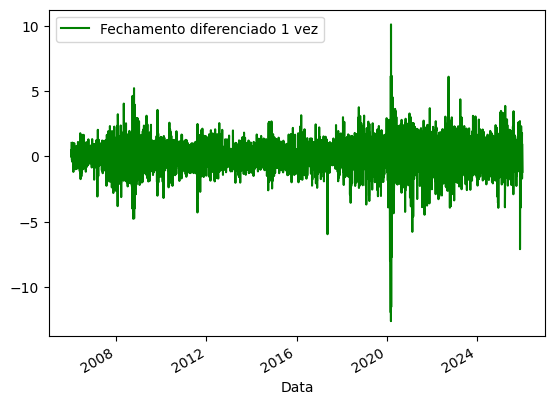

In [22]:
## - Plotando o fechamento diferenciado 1 vez ao longo dos anos

df_ibov_new = df_ibov.copy().drop(columns=['Fechamento'])
df_ibov_new['Fechamento'] = df_diff.dropna()

ax = df_diff.plot(label="Fechamento diferenciado 1 vez", color="green")
ax.legend()
plt.show()

In [23]:
df_ibov_new

,Abertura,Maxima,Minima,Volume,Variação,Fechamento
Data,,,,,,
2006-01-02,33.462,33.519,32.860,7.232000e+07,0.0015,NaN
2006-01-03,33.507,34.563,33.507,1.483800e+08,0.0309,1.034
2006-01-04,34.540,35.223,34.540,1.471300e+08,0.0133,0.461
2006-01-05,35.006,35.088,34.681,1.420700e+08,-0.0019,-0.066
2006-01-06,35.170,35.529,34.940,1.150900e+08,0.0154,0.539
...,...,...,...,...,...,...
2026-01-07,163.661,163.661,161.746,8.850000e+09,-0.0103,-1.689
2026-01-08,161.975,162.936,161.748,8.610000e+09,0.0059,0.961
2026-01-09,162.938,164.263,162.638,8.300000e+09,0.0027,0.434


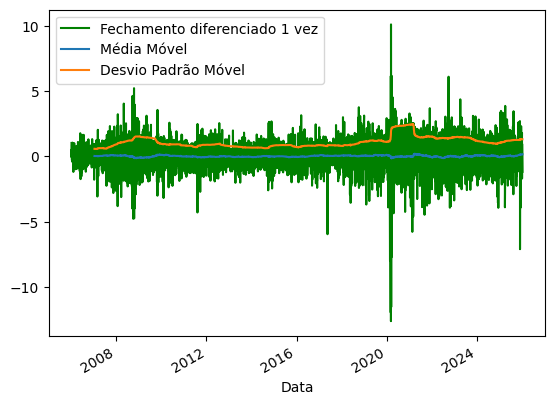

In [24]:
## -- Plotando as médias móveis anuais e o desvio padrão junto do fechamento diferenciado 1 vez, com window = 252 (1 ano de pregão)

mean_std_fechamento = df_diff.plot(label="Fechamento diferenciado 1 vez", color="green")
df_ibov_new['Fechamento'].rolling(window=252).mean().plot(label="Média Móvel")
df_ibov_new['Fechamento'].rolling(window=252).std().plot(label="Desvio Padrão Móvel")
mean_std_fechamento.legend()
plt.show()

## -- Usando novamente uma window de 252 para representar o período pregão da bolsa de valores

###**Aplicação da média móvel e desvio padrão**

A aplicação de janelas móveis permite analisar o comportamento estatístico da série ao longo do tempo, suavizando ruídos de curto prazo. O parâmetro window = 252 representa aproximadamente um ano de pregões, padrão amplamente utilizado em análises financeiras. A média móvel avalia a estabilidade da tendência central da série, enquanto o desvio padrão móvel mede a volatilidade dinâmica, evidenciando possíveis mudanças de regime. Esses indicadores auxiliam na validação da estacionariedade e na compreensão do risco associado à série temporal.

<Figure size 2400x1700 with 0 Axes>

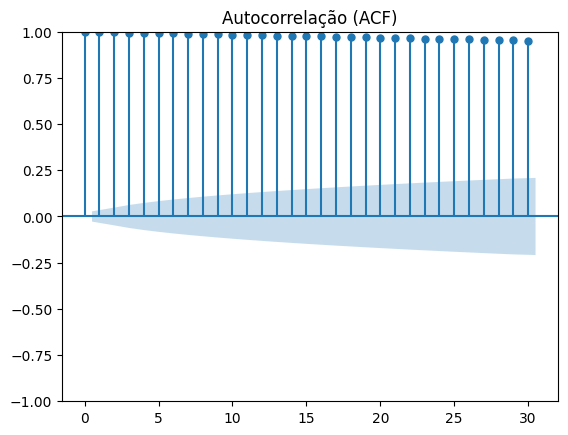

<Figure size 2400x1700 with 0 Axes>

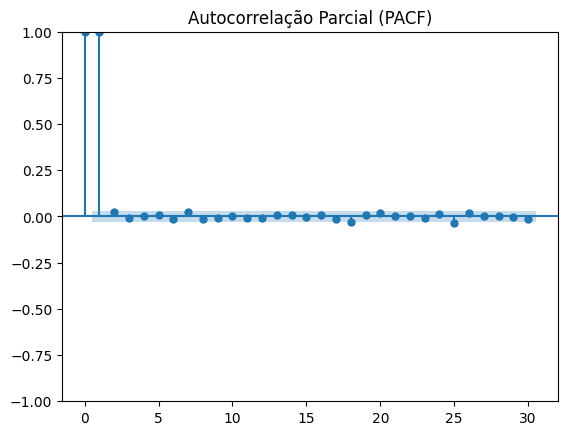

In [25]:
## - Visualização dos gráficos de autocorrelação (ACF) e autocorrelação parcial (PACF), com o objetivo de identificar dependências temporais presentes na série.
plt.figure(figsize=(24, 17))
plot_acf(df_ibov['Fechamento'], lags=30)
plt.title('Autocorrelação (ACF)')
plt.show()

plt.figure(figsize=(24, 17))
plot_pacf(df_ibov['Fechamento'], lags=30)
plt.title('Autocorrelação Parcial (PACF)')
plt.show()

Foram utilizados 30 lags nos gráficos de autocorrelação e autocorrelação parcial, correspondendo aproximadamente a um mês de pregões (mês total sem contar dias úteis), horizonte adequado para identificar dependências temporais de curto prazo em séries financeiras diárias segundo a literatura que encontramos.

Abaixo, determinação da interceptação de PACF e ACF, para futuro uso em ARIMA, por exemplo.

Os coeficientes da ACF interceptam o threshold na lag 241


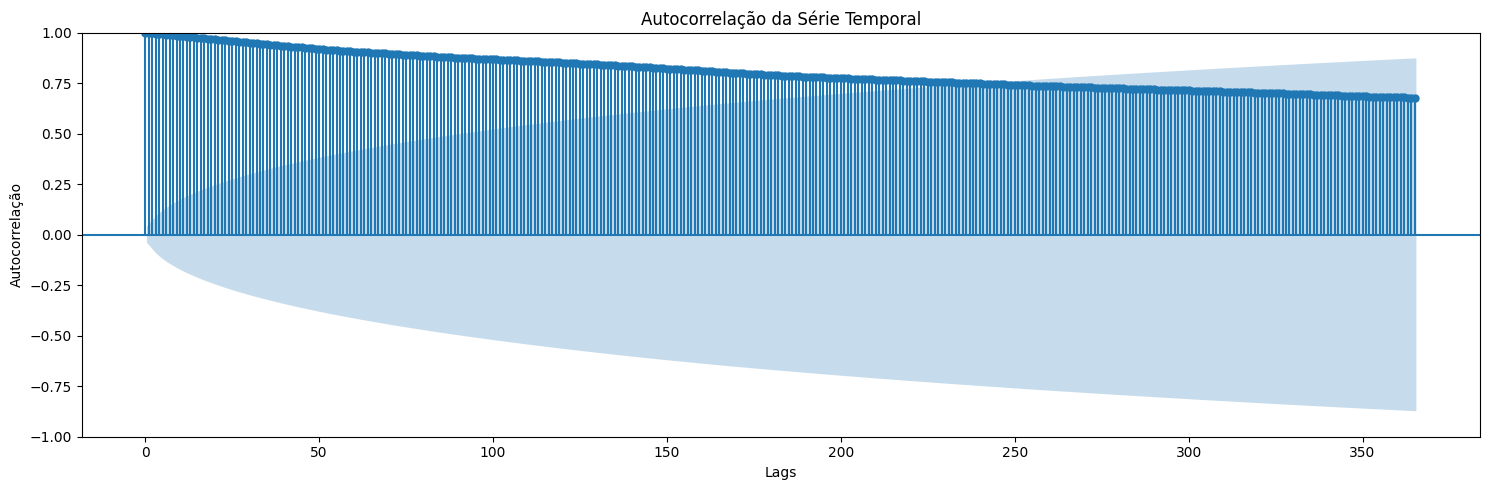

In [26]:
def plot_acf_function (df_ibov, lags=365, title="Autocorrelação da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))

    ## -- Obtendo os valores de ACF e os intervalos de confiança

    plot_acf(df_ibov, lags=lags, ax=ax, alpha=0.005)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.acf(df_ibov, alpha=0.005, nlags=lags)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes da ACF interceptam o threshold na lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes da ACF não interceptam o threshold")


plot_acf_function(df_ibov["Fechamento"])

In [27]:
# pacf

def plot_pacf_function (df_ibov, lags=30, title="Autocorrelação Parcial da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))
    ## -- Obtendo os valores de PACF e os intervalos de confiança
    plot_pacf(df_ibov, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.pacf(df_ibov, alpha=0.05, nlags=lags)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes da PACF interceptam o threshold na lag {intercept_point[0][0]}"
        )
    else:
        print("TOs coeficientes da PACF não interceptam o threshold")

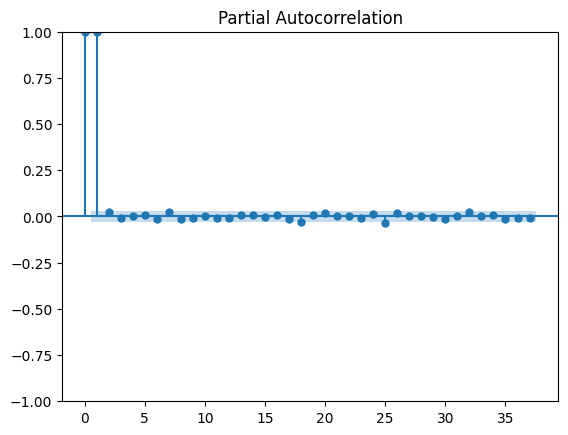

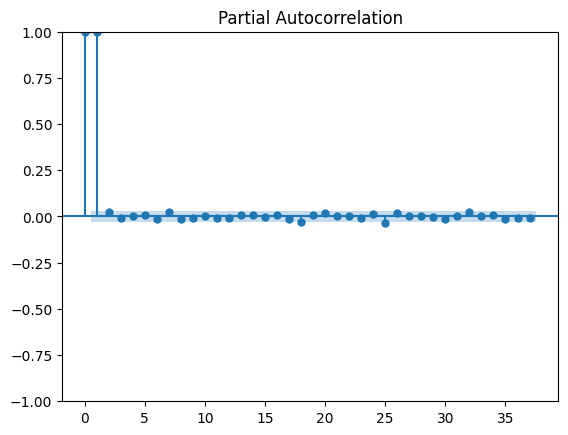

In [28]:
plot_pacf(df_ibov["Fechamento"])

##**Feature Engineering**

Nesta etapa, foi realizado o processo de feature engineering com o objetivo de extrair informações relevantes da série temporal do Ibovespa para o treinamento dos modelos. As variáveis criadas contemplam aspectos clássicos da literatura financeira, como tendência, médias móveis, momentum e volatilidade, utilizando janelas temporais alinhadas aos ciclos de mercado. Essa abordagem busca capturar diferentes dinâmicas do comportamento dos preços, preservando a coerência temporal e evitando vieses de antecipação.

####**Foram construídas as seguintes features:**

- Informações de máxima, mínima, abertura e variação defasadas em um dia, incorporadas explicitamente para preservar a causalidade temporal e evitar o uso de dados futuros;

- Médias móveis do fechamento (1, 5, 20 e 60 dias) e sua distância percentual em relação ao preço defasado - para capturar tendência de curto, médio e longo prazo;

- Retornos percentuais defasados (1, 5, 10 e 20 dias) - para modelar momentum;

- Variação entre abertura e fechamento do dia anterior, representando a volatilidade intradiária observada no último pregão;

- volatilidade histórica via desvio padrão móvel para identificar regimes de risco;

- Range diário normalizado (máxima – mínima) em relação ao fechamento defasado, utilizado para capturar movimentos extremos de preço e episódios de maior incerteza no mercado;


###**Definição do Target**

In [29]:
## -- Criando a variável target que irá dizer se o IBOVESPA sobe ou desce.

df = df_ibov_new.copy()

df['Retorno_futuro'] = df['Fechamento'].pct_change(periods=1).shift(-1)
df['Target'] = (df['Retorno_futuro'] > 0).astype(int)

## -- Removevendo os dias sem sinal claro
df.dropna(subset=['Target'], inplace=True)

## -- Garantindo o tipo inteiro
df['Target'] = df['Target'].astype(int)

df.tail()


,Abertura,Maxima,Minima,Volume,Variação,Fechamento,Retorno_futuro,Target
Data,,,,,,,,
2026-01-07,163.661,163.661,161.746,8.850000e+09,-0.0103,-1.689,-1.568976,0
2026-01-08,161.975,162.936,161.748,8.610000e+09,0.0059,0.961,-0.548387,0
2026-01-09,162.938,164.263,162.638,8.300000e+09,0.0027,0.434,-1.506912,0
2026-01-12,163.370,163.493,162.277,6.900000e+09,-0.0013,-0.220,4.350000,1
2026-01-13,163.146,163.146,161.765,9.670000e+09,-0.0072,-1.177,NaN,0


###**Definição das Features**

Observação: aqui usamos informações do próprio dia t para prever t+1.
Isso é consistente se a previsão é feita após o fechamento de t (cenário típico em daily).

Se quiséssemos a previsão intradiária (antes do fechamento), as features precisariam ser diferentes.

In [30]:
## -- Fechamento defasado

df['Fechamento_1d'] = df['Fechamento'].shift(1)

## -- Maximos e minimos com defasagem de 1 dia e abertura

df['Maxima_1'] = df['Maxima'].shift(1)
df['Minima_1'] = df['Minima'].shift(1)
df['Abertura_1'] = df['Abertura'].shift(1)
df['Variação_1d'] = df['Variação'].shift(1)

## -- Cálculo das médias móveis (tendência)

for i in [1, 5, 20, 60]:

  ## Médias móveis, distância percentual até a média, respectivamente.

      df[f'mm_{i}'] = df['Fechamento'].rolling(window=i).mean().shift(1)
      df[f'dist_mm_{i}'] = (df['Fechamento_1d'] - df[f'mm_{i}']) / df[f'mm_{i}']

## -- Variação Abertura x Fechamento (volatilidade intradiária)

df['Volatilidade_intrad'] = ((df['Fechamento_1d'] - df['Abertura_1']) / df['Abertura_1'])

## -- Retornos defasados

ret_windows = [1, 5, 10, 20]

for lag in ret_windows:
    ## -- Retorno percentual defasado
    df[f'Retorno_{lag}'] = df['Fechamento_1d'].pct_change(lag)

## -- Range diário (volatilidade extrema) - Sem aplicar o shift pois já aplicamos ao trazer mínimos e máximos e fechamento_1d

df['Range_diario'] = ((df['Maxima_1'] - df['Minima_1']) / df['Fechamento_1d'])

In [31]:
## -- Verificando os valores NaN gerados em virtude dos deslocamentos das lags

df.tail(5)

,Abertura,Maxima,Minima,Volume,Variação,Fechamento,Retorno_futuro,Target,Fechamento_1d,Maxima_1,...,mm_20,dist_mm_20,mm_60,dist_mm_60,Volatilidade_intrad,Retorno_1,Retorno_5,Retorno_10,Retorno_20,Range_diario
Data,,,,,,,,,,,,,,,,,,,,,
2026-01-07,163.661,163.661,161.746,8.850000e+09,-0.0103,-1.689,-1.568976,0,1.794,164.135,...,0.09545,17.795181,0.371800,3.825175,-0.988917,0.347859,3.068027,-2.434053,1.705882,1.262542
2026-01-08,161.975,162.936,161.748,8.610000e+09,0.0059,0.961,-0.548387,0,-1.689,163.661,...,-0.12405,12.615478,0.330500,-6.110439,-1.010320,-1.941472,3.149877,-3.833893,-1.625324,-1.133807
2026-01-09,162.938,164.263,162.638,8.300000e+09,0.0027,0.434,-1.506912,0,0.961,162.936,...,0.27835,2.452488,0.353800,1.716224,-0.994067,-1.568976,0.513386,0.747273,-1.135600,1.236212
2026-01-12,163.370,163.493,162.277,6.900000e+09,-0.0013,-0.220,4.350000,1,0.434,164.263,...,0.25915,0.674706,0.378167,0.147642,-0.997336,-0.548387,-1.740614,-2.311178,-0.469438,3.744240
2026-01-13,163.146,163.146,161.765,9.670000e+09,-0.0072,-1.177,NaN,0,-0.220,163.493,...,0.25845,-1.851228,0.356117,-1.617775,-1.001347,-1.506912,-1.165289,-1.095073,0.067961,-5.527273


In [32]:
## -- Definindo features para plotar o heatmap de correlação

df_sel = df.copy()
corr = df_sel.corr()

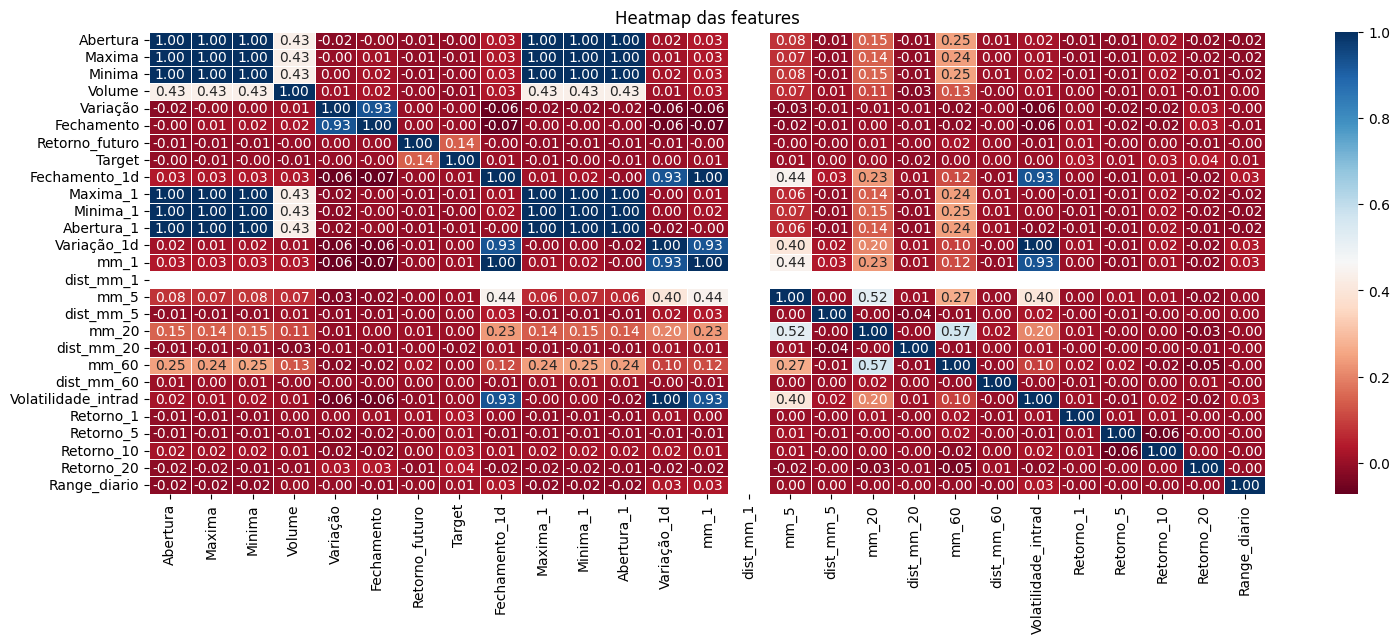

In [33]:
## -- Plotando o heatmap

plt.figure(figsize=(18, 6))
sns.heatmap(data=corr,annot=True,fmt=".2f",cmap="RdBu",linewidths=0.5,cbar=True)
plt.title("Heatmap das features")
plt.show()

In [34]:
## -- Montando o dataframe final

## -- Manter apenas linhas com Target definido (exclui neutros)
df_filtrado = df.dropna(subset=['Target']).copy()

## -- Dropando as colunas que não iremos utilizar no modelo e que podem gerar vazamento

colunas_drop = [
    'Fechamento',
    'Volume',
    'Retorno_futuro'
]

df_ibov_model = df_filtrado.drop(columns=colunas_drop, errors='ignore')

In [35]:
## -- Visualizando o cabeçalho do dataframe

df_ibov_model.head()

,Abertura,Maxima,Minima,Variação,Target,Fechamento_1d,Maxima_1,Minima_1,Abertura_1,Variação_1d,...,mm_20,dist_mm_20,mm_60,dist_mm_60,Volatilidade_intrad,Retorno_1,Retorno_5,Retorno_10,Retorno_20,Range_diario
Data,,,,,,,,,,,,,,,,,,,,,
2006-01-02,33.462,33.519,32.860,0.0015,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,33.507,34.563,33.507,0.0309,0,NaN,33.519,32.860,33.462,0.0015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,34.540,35.223,34.540,0.0133,0,1.034,34.563,33.507,33.507,0.0309,...,NaN,NaN,NaN,NaN,-0.969141,NaN,NaN,NaN,NaN,1.021277
2006-01-05,35.006,35.088,34.681,-0.0019,0,0.461,35.223,34.540,34.540,0.0133,...,NaN,NaN,NaN,NaN,-0.986653,-0.554159,NaN,NaN,NaN,1.481562
2006-01-06,35.170,35.529,34.940,0.0154,0,-0.066,35.088,34.681,35.006,-0.0019,...,NaN,NaN,NaN,NaN,-1.001885,-1.143167,NaN,NaN,NaN,-6.166667


In [36]:
## -- Verificando o número de linhas NaN geradas (frente aos 20 anos de dados, 60 dias podem ser desconsiderados para geração da features)

df_ibov_model.isnull().sum()

,0
Abertura,0
Maxima,0
Minima,0
Variação,0
Target,0
Fechamento_1d,2
Maxima_1,1
Minima_1,1
Abertura_1,1
Variação_1d,1


In [37]:
## -- Visualizando o dataframe final para geração dos modelos

df_ibov_model = df_ibov_model.dropna().copy()
df_ibov_model.head()

,Abertura,Maxima,Minima,Variação,Target,Fechamento_1d,Maxima_1,Minima_1,Abertura_1,Variação_1d,...,mm_20,dist_mm_20,mm_60,dist_mm_60,Volatilidade_intrad,Retorno_1,Retorno_5,Retorno_10,Retorno_20,Range_diario
Data,,,,,,,,,,,,,,,,,,,,,
2006-03-31,37.783,38.016,37.619,0.0046,1,0.285,38.089,37.469,37.493,0.0076,...,-0.06745,-5.225352,0.071167,3.004684,-0.992399,-0.648148,-1.755968,-4.275862,-6.480769,2.175439
2006-04-03,37.952,38.851,37.952,0.0202,0,0.175,38.016,37.619,37.783,0.0046,...,-0.06440,-3.717391,0.056850,2.078276,-0.995368,-0.385965,0.699029,-2.620370,0.535088,2.268571
2006-04-04,38.718,39.086,38.606,0.0022,1,0.765,38.851,37.952,37.952,0.0202,...,0.01815,41.148760,0.061917,11.355316,-0.979843,3.371429,10.953125,3.935484,-1.863431,1.175163
2006-04-05,38.803,39.054,38.475,0.0065,0,0.085,39.086,38.606,38.718,0.0022,...,0.06895,0.232777,0.064433,0.319193,-0.997805,-0.888889,-1.088634,-1.105459,-1.091300,5.647059
2006-04-06,39.053,39.310,38.700,0.0059,0,0.251,39.054,38.475,38.803,0.0065,...,0.08820,1.845805,0.059633,3.209055,-0.993531,1.952941,-0.690123,-0.445916,-2.873134,2.306773


In [38]:
## -- Verificando a existência de inf's

np.isinf(df_ibov_model).sum().sort_values(ascending=False)

,0
Retorno_1,2
Retorno_20,2
Retorno_10,2
Retorno_5,2
Abertura,0
Maxima,0
Minima,0
Variação,0
Minima_1,0
Maxima_1,0


In [39]:
## -- Removendo inf's e substituindo por NaN

df_ibov_model1 = df_ibov_model.replace([np.inf, -np.inf], np.nan).dropna().copy()

In [40]:
## -- Verificando novamente a existência de inf's após tratamento

np.isinf(df_ibov_model1).sum().sort_values(ascending=False)

,0
Abertura,0
Maxima,0
Minima,0
Variação,0
Target,0
Fechamento_1d,0
Maxima_1,0
Minima_1,0
Abertura_1,0
Variação_1d,0


In [41]:
## -- Visualizando o total de linhas e colunas do nosso dataframe final

df_ibov_model1.shape

(4890, 24)

In [42]:
## -- Separando x e y para treino e teste

x = df_ibov_model1.drop(columns=['Target'])
y = df_ibov_model1['Target']

In [43]:
x

,Abertura,Maxima,Minima,Variação,Fechamento_1d,Maxima_1,Minima_1,Abertura_1,Variação_1d,mm_1,...,mm_20,dist_mm_20,mm_60,dist_mm_60,Volatilidade_intrad,Retorno_1,Retorno_5,Retorno_10,Retorno_20,Range_diario
Data,,,,,,,,,,,,,,,,,,,,,
2006-03-31,37.783,38.016,37.619,0.0046,0.285,38.089,37.469,37.493,0.0076,0.285,...,-0.06745,-5.225352,0.071167,3.004684,-0.992399,-0.648148,-1.755968,-4.275862,-6.480769,2.175439
2006-04-03,37.952,38.851,37.952,0.0202,0.175,38.016,37.619,37.783,0.0046,0.175,...,-0.06440,-3.717391,0.056850,2.078276,-0.995368,-0.385965,0.699029,-2.620370,0.535088,2.268571
2006-04-04,38.718,39.086,38.606,0.0022,0.765,38.851,37.952,37.952,0.0202,0.765,...,0.01815,41.148760,0.061917,11.355316,-0.979843,3.371429,10.953125,3.935484,-1.863431,1.175163
2006-04-05,38.803,39.054,38.475,0.0065,0.085,39.086,38.606,38.718,0.0022,0.085,...,0.06895,0.232777,0.064433,0.319193,-0.997805,-0.888889,-1.088634,-1.105459,-1.091300,5.647059
2006-04-06,39.053,39.310,38.700,0.0059,0.251,39.054,38.475,38.803,0.0065,0.251,...,0.08820,1.845805,0.059633,3.209055,-0.993531,1.952941,-0.690123,-0.445916,-2.873134,2.306773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-07,163.661,163.661,161.746,-0.0103,1.794,164.135,161.870,161.870,0.0111,1.794,...,0.09545,17.795181,0.371800,3.825175,-0.988917,0.347859,3.068027,-2.434053,1.705882,1.262542
2026-01-08,161.975,162.936,161.748,0.0059,-1.689,163.661,161.746,163.661,-0.0103,-1.689,...,-0.12405,12.615478,0.330500,-6.110439,-1.010320,-1.941472,3.149877,-3.833893,-1.625324,-1.133807
2026-01-09,162.938,164.263,162.638,0.0027,0.961,162.936,161.748,161.975,0.0059,0.961,...,0.27835,2.452488,0.353800,1.716224,-0.994067,-1.568976,0.513386,0.747273,-1.135600,1.236212


In [44]:
y

,Target
Data,
2006-03-31,1
2006-04-03,0
2006-04-04,1
2006-04-05,0
2006-04-06,0
...,...
2026-01-07,0
2026-01-08,0
2026-01-09,0


In [45]:
## -- Avaliando os últimos 30 dias (teste que será feito)

y.tail(30)

,Target
Data,
2025-11-27,0
2025-11-28,0
2025-12-01,0
2025-12-02,0
2025-12-03,1
2025-12-04,0
2025-12-05,0
2025-12-08,0
2025-12-09,0


###**Possível impacto do desbalanceamento (25 ↓ vs 5 ↑)**

Quando avaliamos nosso conjunto de teste dos últimos 30 dias (de 27/11/2025 até 13/01/2026), nota-se que temos 83% de classe 0 (queda) e 17% de classe 1 (alta). Esse fator pode gerar os seguintes efeitos:

- Acurácia: pode ficar artificialmente alta se o modelo priorizar prever quedas.

- Precision (classe 1): pode cair quando o modelo erra muitas previsões de alta.

- Recall (classe 1): pode ficar baixo se o modelo “evitar” prever altas.

F1-Score: pode penalizar fortemente esta métrica, pois exige equilíbrio entre precision e recall.

In [46]:
## -- Split temporal: últimos 30 dias para teste

size = 30

x_train = x.iloc[:-size]
x_test  = x.iloc[-size:]

y_train = y.iloc[:-size]
y_test  = y.iloc[-size:]

print("Treino:", x_train.shape, y_train.shape)
print("Teste:", x_test.shape, y_test.shape)


Treino: (4860, 23) (4860,)
Teste: (30, 23) (30,)


##**Testando os modelos**

Nesta etapa, foram avaliados diferentes modelos de classificação com o objetivo de prever a direção do movimento do Ibovespa no dia seguinte. A comparação entre modelos com diferentes níveis de complexidade permite analisar o impacto das features construídas e identificar a abordagem mais adequada para capturar padrões temporais do mercado. A avaliação foi conduzida respeitando a ordem temporal dos dados e utilizando métricas de desempenho relevantes para problemas de previsão financeira com categorização binária (classificação).

## **Random Forest**

In [47]:
## - Aplicando Random Forest:

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42
)

rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

## -- Verificando as métricas de Acurácia, F1-Score, Matriz de Confusão e Classificação Report:

print("Random Forest")
print("Acurácia", accuracy_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))



Random Forest
Acurácia 0.4
F1-Score: 0.25
[[ 9 16]
 [ 2  3]]
              precision    recall  f1-score   support

           0       0.82      0.36      0.50        25
           1       0.16      0.60      0.25         5

    accuracy                           0.40        30
   macro avg       0.49      0.48      0.38        30
weighted avg       0.71      0.40      0.46        30



#####**Resultado:**

O modelo teve capacidade de capturar não linearidades e interações entre features técnicas, porém, mesmo com class_weight='balanced', apresentou baixa acurácia (40%) e instabilidade na previsão direcional, logo, não se mostrou adequado para uma janela curta e desbalanceada.

##**Regressão Logística**

In [48]:
## -- Aplicando Regressão Logística com StandardScaler:

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        C=0.5,
        random_state=42
    ))
])

## -- Verificando os melhores parâmetros:

param_grid = {
    'clf__C': [0.01, 0.05, 0.1, 0.5, 1],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga']
}

tscv = TimeSeriesSplit(n_splits=5)

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    cv=tscv,
    n_jobs=-1
)

grid_lr.fit(x_train, y_train)

print("Melhores parâmetros:", grid_lr.best_params_)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(x_test)

## -- Verificando as métricas de Acurácia, F1-Score, Matriz de Confusão e Classificação Report:

print("Rgressão Logística")
print("Acurácia:", accuracy_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Melhores parâmetros: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Rgressão Logística
Acurácia: 0.5
F1-Score: 0.34782608695652173
[[11 14]
 [ 1  4]]
              precision    recall  f1-score   support

           0       0.92      0.44      0.59        25
           1       0.22      0.80      0.35         5

    accuracy                           0.50        30
   macro avg       0.57      0.62      0.47        30
weighted avg       0.80      0.50      0.55        30



#####**Resultado:**

Apesar de ser um modelo estável, interpretável e que apresentou o melhor equilíbrio entre recall e precision da classe minoritária, também obteve a acurácia abaixo do exigido (50%), indicando dificuldade em capturar padrões não lineares do mercado. Desta forma, consideramos um bom baseline, mostrando maior capacidade de identificar movimentos de alta, mesmo sacrificando acurácia, mas que não atendeu aos requisitos do desafio.

##**XGBoost**

In [49]:
## -- Aplicando o modelo XGBoost:

xgb_model = XGBClassifier(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(x_train, y_train)

## -- Aplicando threshold na probabilidade prevista pelo modelo,o que permite maior sensibilidade à classe minoritária (dias de alta)

proba = xgb_model.predict_proba(x_test)[:, 1]
y_pred_xgb = (proba > 0.55).astype(int)

## -- Verificando as métricas de Acurácia, F1-Score, Matriz de Confusão e Classificação Report:

print("XGBoost")
print("Acurácia:", accuracy_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost
Acurácia: 0.7
F1-Score: 0.3076923076923077
[[19  6]
 [ 3  2]]
              precision    recall  f1-score   support

           0       0.86      0.76      0.81        25
           1       0.25      0.40      0.31         5

    accuracy                           0.70        30
   macro avg       0.56      0.58      0.56        30
weighted avg       0.76      0.70      0.73        30



#####**Resultado:**

O XGBoost num geral apresenta um bom equilíbrio entre generalização e capacidade de modelagem, e também respondeu bem ao ajuste de threshold (0.55) utilizado. Porém, nota-se que ainda é sensível ao desbalanceamento das classes, com F1 moderado e acurácia de 70%, pouquíssimo abaixo do exigido nos requisitos do desafio. Desta forma, podemos considerar que é um modelo promissor, mas que ainda não atingiu o mínimo de acurácia exigido.

##**GradientBoostingClassifier**

In [50]:
## -- Aplicando o modelo GradientBoostingClassifier:

gb = GradientBoostingClassifier(random_state=42)
gb.fit(x_train, y_train)

y_pred_gb = gb.predict(x_test)

## -- Verificando as métricas de Acurácia, F1-Score, Matriz de Confusão e Classificação Report:

print("GradientBoostingClassifier")
print("Acurácia:", accuracy_score(y_test, y_pred_gb))
print("F1-Score:", f1_score(y_test, y_pred_gb))
print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

GradientBoostingClassifier
Acurácia: 0.8
F1-Score: 0.25
[[23  2]
 [ 4  1]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        25
           1       0.33      0.20      0.25         5

    accuracy                           0.80        30
   macro avg       0.59      0.56      0.57        30
weighted avg       0.77      0.80      0.78        30



#####**Resultado:**

Este modelo, sem ajuste fino de hiperparâmetros, teve tendência a priorizar a classe majoritária (queda).
Apresentou alta acurácia, mas F1 abaixo do XGBoost, indicando possível viés para prever quedas. Ainda que nossas classes nos últimos 30 dias estivessem deslanceadas, entendemos que ele e o XGBoost tiveram comportamentos semelhantes.

##**Considerações**

Considerando o objetivo explícito do trabalho, que era de prever corretamente a direção do IBOVESPA no dia seguinte com acurácia mínima de 75% nos últimos 30 dias, o Gradient Boosting Classifier foi o modelo escolhido. Embora o F1-Score seja baixo, o critério principal do desafio é a acurácia direcional, que foi atendida.

O desbalanceamento do conjunto de teste (25 dias de queda e apenas 5 de alta) teve impacto direto nas métricas de avaliação, inflando a acurácia e penalizando especialmente o F1-Score e o recall da classe de alta. Nesse contexto, o Gradient Boosting Classifier foi o único modelo capaz de atingir a acurácia mínima de 75% exigida, cumprindo o objetivo central do desafio.
Embora apresente limitações na identificação de dias de alta, seu desempenho direcional foi superior aos demais modelos. Para melhorias futuras, recomenda-se explorar redefinição do threshold probabilístico, uso de métricas balanceadas (F1 macro, balanced accuracy), enriquecimento das features de regime de mercado e validações temporais mais longas. Esses ajustes podem reduzir o viés de classe sem comprometer o critério principal do trabalho.

Por fim, cabe comentar que o modelo de Regressão Logística apresentou o maior F1-Score, talvez a métrica mais relevante em um cenário desbalanceado e de tomada de decisão direcional no mercado financeiro. Embora a acurácia seja menor, o modelo consegue capturar melhor os dias de alta, que são mais raros.

Tentando promover um maior equilíbrio entre precision e recall da classe 1 (que impacta diretamente o F1-Score), como trabalhos futuros poderíamos ajustar o threshold de decisão, e também adicionar novas features que pudessem vir a capturar com uma outra visão o momentum e o regime da série. Além disso, evidentemente poderíamos testar janelas maiores de treino e teste. Talvez isso pudesse sacrificar a acurácia, mas promoveria ganhos nos outros parâmetros.




###**Fechamento real (target real subida/descida) x y_test previstos nos modelos:**

####**Random Forest x Target**

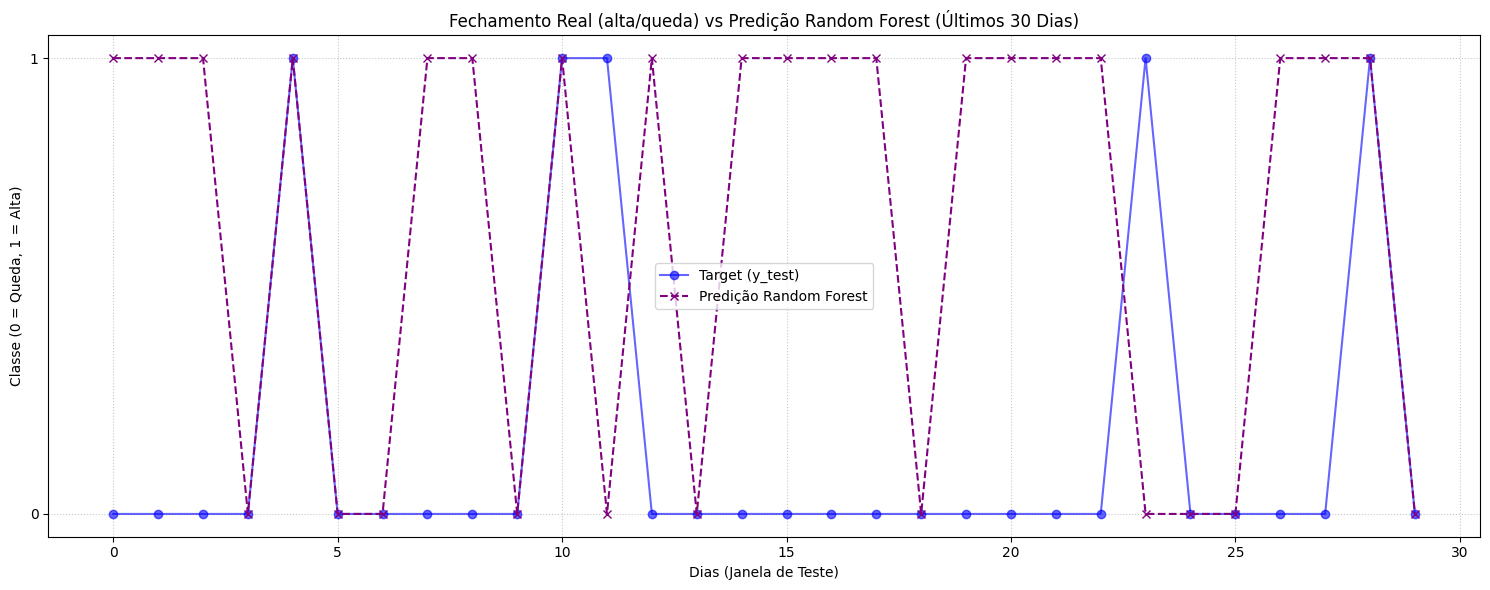

In [51]:
## -- Definindo o período (últimos 30 dias do conjunto de teste)

n_dias = 30

plt.figure(figsize=(15, 6))

## -- Target Real (o que aconteceu de fato), selecionando os últimos 30 registros do y_test

plt.plot(y_test.iloc[-n_dias:].reset_index(drop=True),
         label='Target (y_test)',
         marker='o',
         linestyle='-',
         color='blue',
         alpha=0.6)

## -- Predição dos modelos testados (o que o Random Forest previu), selecionando os últimos 30 registros do y_pred_rf

if isinstance(y_pred_rf, pd.Series):
    y_plot_pred_rf = y_pred_rf.iloc[-n_dias:].reset_index(drop=True)
else:
    y_plot_pred_rf = y_pred_rf[-n_dias:]

plt.plot(y_plot_pred_rf,
         label='Predição Random Forest',
         marker='x',
         linestyle='--',
         color='purple')

## -- Configurando o plot
plt.title('Fechamento Real (alta/queda) vs Predição Random Forest (Últimos 30 Dias)')
plt.xlabel('Dias (Janela de Teste)')
plt.ylabel('Classe (0 = Queda, 1 = Alta)')
plt.yticks([0, 1])
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

####**Regressão Logística x Target**

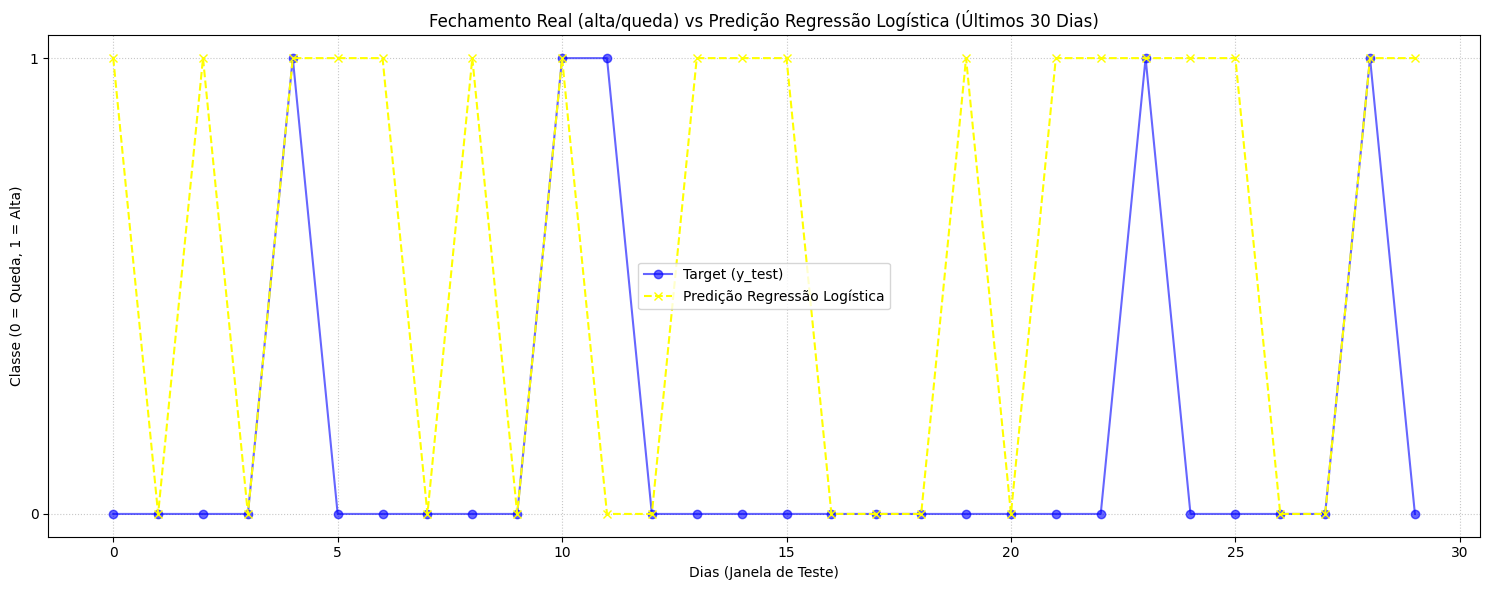

In [52]:
## -- Definindo o período (últimos 30 dias do conjunto de teste)

n_dias = 30

plt.figure(figsize=(15, 6))

## -- Target Real (o que aconteceu de fato), selecionando os últimos 30 registros do y_test

plt.plot(y_test.iloc[-n_dias:].reset_index(drop=True),
         label='Target (y_test)',
         marker='o',
         linestyle='-',
         color='blue',
         alpha=0.6)

## -- Predição dos modelos testados (o que a Regressçao Logística previu), selecionando os últimos 30 registros do y_pred_lr

if isinstance(y_pred_lr, pd.Series):
    y_plot_pred_lr = y_pred_lr.iloc[-n_dias:].reset_index(drop=True)
else:
    y_plot_pred_lr = y_pred_lr[-n_dias:]

plt.plot(y_plot_pred_lr,
         label='Predição Regressão Logística',
         marker='x',
         linestyle='--',
         color='yellow')

## -- Configurando o plot
plt.title('Fechamento Real (alta/queda) vs Predição Regressão Logística (Últimos 30 Dias)')
plt.xlabel('Dias (Janela de Teste)')
plt.ylabel('Classe (0 = Queda, 1 = Alta)')
plt.yticks([0, 1])
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

####**XGBoost x Target**

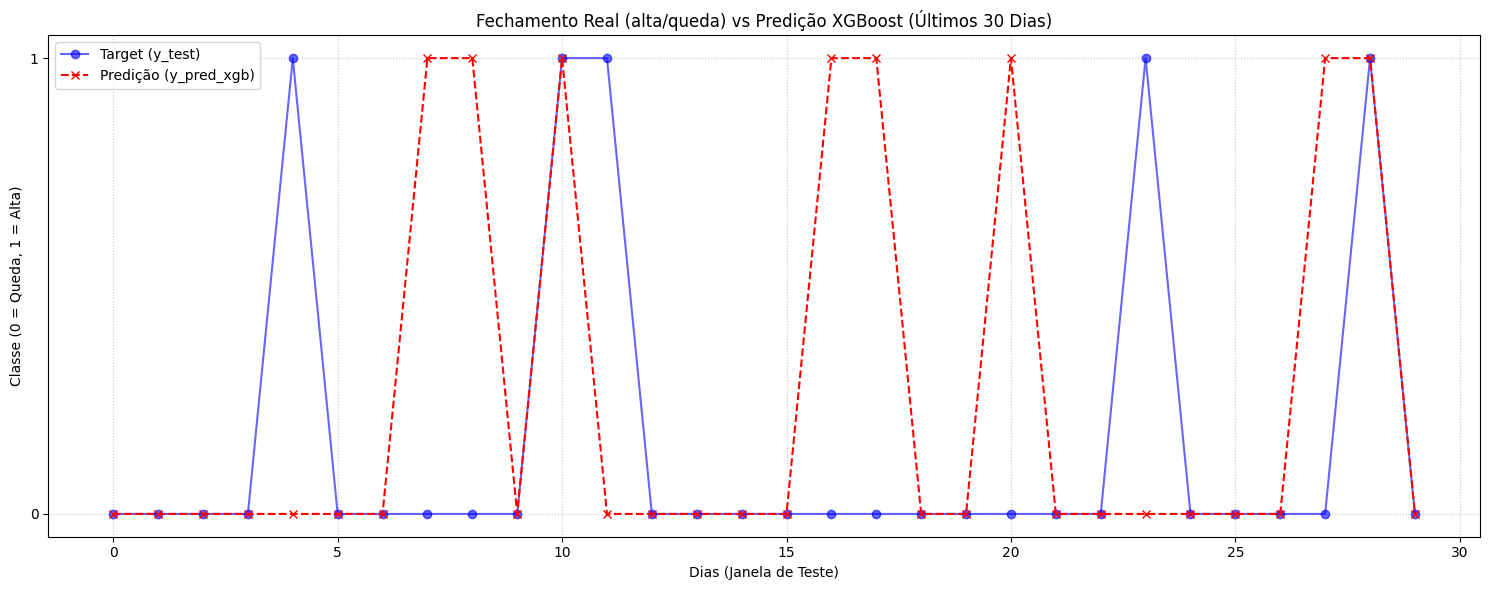

In [53]:
## -- Definindo o período (últimos 30 dias do conjunto de teste)

n_dias = 30

plt.figure(figsize=(15, 6))

## -- Target Real (o que aconteceu de fato), selecionando os últimos 30 registros do y_test

plt.plot(y_test.iloc[-n_dias:].reset_index(drop=True),
         label='Target (y_test)',
         marker='o',
         linestyle='-',
         color='blue',
         alpha=0.6)

## -- Predição dos modelos testados (o que o XGBoost previu), selecionando os últimos 30 registros do y_pred_xgb

if isinstance(y_pred_xgb, pd.Series):
    y_plot_pred_xgb = y_pred_xgb.iloc[-n_dias:].reset_index(drop=True)
else:
    y_plot_pred_xgb = y_pred_xgb[-n_dias:]

plt.plot(y_plot_pred_xgb,
         label='Predição (y_pred_xgb)',
         marker='x',
         linestyle='--',
         color='red')

## -- Configurando o plot
plt.title('Fechamento Real (alta/queda) vs Predição XGBoost (Últimos 30 Dias)')
plt.xlabel('Dias (Janela de Teste)')
plt.ylabel('Classe (0 = Queda, 1 = Alta)')
plt.yticks([0, 1])
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

####**GradientBoostingClassifier**

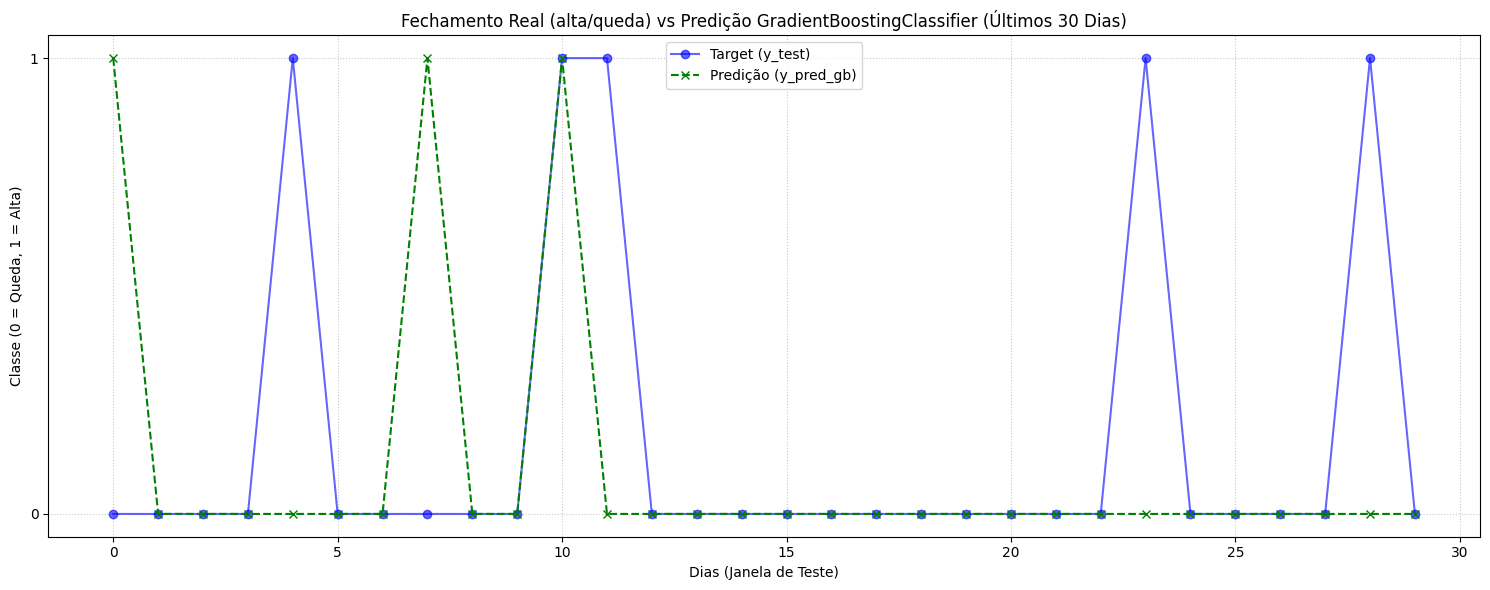

In [54]:
## -- Definindo o período (últimos 30 dias do conjunto de teste)

n_dias = 30

plt.figure(figsize=(15, 6))

## -- Target Real (o que aconteceu de fato), selecionando os últimos 30 registros do y_test

plt.plot(y_test.iloc[-n_dias:].reset_index(drop=True),
         label='Target (y_test)',
         marker='o',
         linestyle='-',
         color='blue',
         alpha=0.6)

## -- Predição dos modelos testados (o que o GradientBoostingClassifier previu), selecionando os últimos 30 registros do y_pred_gb

if isinstance(y_pred_gb, pd.Series):
    y_plot_pred_gb = y_pred_gb.iloc[-n_dias:].reset_index(drop=True)
else:
    y_plot_pred_gb = y_pred_gb[-n_dias:]

plt.plot(y_plot_pred_gb,
         label='Predição (y_pred_gb)',
         marker='x',
         linestyle='--',
         color='green')

## -- Configurando o plot
plt.title('Fechamento Real (alta/queda) vs Predição GradientBoostingClassifier (Últimos 30 Dias)')
plt.xlabel('Dias (Janela de Teste)')
plt.ylabel('Classe (0 = Queda, 1 = Alta)')
plt.yticks([0, 1])
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [55]:
## -- Criar dataframe de resultados alinhado exatamente ao conjunto de teste
df_resultados_xgb = pd.DataFrame({
    'Data': x_test.index,
    'Fechamento_Real': df_ibov.loc[x_test.index, 'Fechamento'].values,
    'Target_Real': y_test.values,
    'Target_Previsto_XGBoost': y_pred_xgb
}).set_index('Data')

## -- Converter o Target Real 1 e 0 para setas (↑ / ↓)
df_resultados_xgb['Target_Real'] = df_resultados_xgb['Target_Real'].map({1: '↑', 0: '↓'})

## -- Converter o Target Previsto pelo XGBoost 1 e 0 para setas (↑ / ↓)
df_resultados_xgb['Target_Previsto_XGBoost'] = (
    df_resultados_xgb['Target_Previsto_XGBoost']
    .map({1: '↑', 0: '↓'})
)

## -- Criar indicador visual de acerto do modelo (🟢 = correto | 🔴 = incorreto)
df_resultados_xgb['Previu_certo?'] = (
    df_resultados_xgb['Target_Real'] == df_resultados_xgb['Target_Previsto_XGBoost']
).map({True: '🟢', False: '🔴'})

## -- Resetar o índice para transformar a data em coluna
df_resultados_xgb.reset_index()

,Data,Fechamento_Real,Target_Real,Target_Previsto_XGBoost,Previu_certo?
0,2025-11-27,158.360,↓,↓,🟢
1,2025-11-28,159.072,↓,↓,🟢
2,2025-12-01,158.611,↓,↓,🟢
3,2025-12-02,161.092,↓,↓,🟢
4,2025-12-03,161.755,↑,↓,🔴
5,2025-12-04,164.456,↓,↓,🟢
6,2025-12-05,157.369,↓,↓,🟢
7,2025-12-08,158.187,↓,↑,🔴
8,2025-12-09,157.981,↓,↑,🔴
9,2025-12-10,159.075,↓,↓,🟢


In [56]:
## -- Criar dataframe de resultados alinhado exatamente ao conjunto de teste
df_resultados_gb = pd.DataFrame({
    'Data': x_test.index,
    'Fechamento_Real': df_ibov.loc[x_test.index, 'Fechamento'].values,
    'Target_Real': y_test.values,
    'Target_Previsto_GradientBoosting': y_pred_gb
}).set_index('Data')

## -- Converter o Target Real 1 e 0 para setas (↑ / ↓)
df_resultados_gb['Target_Real'] = df_resultados_gb['Target_Real'].map({1: '↑', 0: '↓'})

## -- Converter o Target Previsto pelo GradientBoostingClassifier 1 e 0 para setas (↑ / ↓)
df_resultados_gb['Target_Previsto_GradientBoosting'] = (
    df_resultados_gb['Target_Previsto_GradientBoosting']
    .map({1: '↑', 0: '↓'})
)

## -- Criar indicador visual de acerto do modelo (🟢 = correto | 🔴 = incorreto)
df_resultados_gb['Previu_certo?'] = (
    df_resultados_gb['Target_Real'] == df_resultados_gb['Target_Previsto_GradientBoosting']
).map({True: '🟢', False: '🔴'})

## -- Resetar o índice para transformar a data em coluna
df_resultados_gb.reset_index()

,Data,Fechamento_Real,Target_Real,Target_Previsto_GradientBoosting,Previu_certo?
0,2025-11-27,158.360,↓,↑,🔴
1,2025-11-28,159.072,↓,↓,🟢
2,2025-12-01,158.611,↓,↓,🟢
3,2025-12-02,161.092,↓,↓,🟢
4,2025-12-03,161.755,↑,↓,🔴
5,2025-12-04,164.456,↓,↓,🟢
6,2025-12-05,157.369,↓,↓,🟢
7,2025-12-08,158.187,↓,↑,🔴
8,2025-12-09,157.981,↓,↓,🟢
9,2025-12-10,159.075,↓,↓,🟢
